2023/3/7<br>
Code is for measurement cell wall thickness

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
from skimage import measure
from tqdm import tqdm
from matplotlib import cm
from skimage.draw import line
from skimage.filters import threshold_otsu
import multiprocessing as mp
from multiprocessing import Pool
from common.cw_measure import *

In [2]:
resolution=0.160256 #um/pixel
core_num=8

In [3]:
current_path=os.getcwd()
npz_path=os.path.join(current_path, "npz_file")
target_npz_path=os.path.join(npz_path, "Dataframe_MFA_anatomy.npz")
npz_segmentation_path=os.path.join(npz_path, "segmentation")
npz_pred_path=os.path.join(npz_path, "pred_im_concatenation")

npz_segmentation_files=glob.glob(os.path.join(npz_segmentation_path, "*.npz"))
npz_pred_files=glob.glob(os.path.join(npz_pred_path, "*.npz"))

npz_df=np.load(target_npz_path, allow_pickle=True)
df_list=npz_df["df_list"]

In [4]:
df_cwt_list=[]
for i, (npz_segmentation, npz_pred) in enumerate(zip(npz_segmentation_files, npz_pred_files)):
    #load npz
    npz_segmentation=np.load(npz_segmentation)
    nuclei=npz_segmentation["nuclei"]
    #
    npz_pred=np.load(npz_pred)
    MFA=npz_pred["MFA"]
    #
    df=df_list[i]
    
    #define cwall_mat
    cwall_mat=np.where(MFA>0, 255, 0)
    
    #call class
    length_list=np.repeat(int(6/resolution) , len(df)+1)
    cellwall_auto_measure_mp=cellwall_measure_mp(core_num, np.uint(cwall_mat), nuclei, resolution, length_list, cwall_thres=90)
    
    #calculate CWT
    with Pool(core_num) as p:
        #calculation MFA using cores 
        callback_cw = p.map(cellwall_auto_measure_mp.cwall_measure_mp, range(core_num))
        
    #summarize results
    result_list=[]
    for i in tqdm(range(len(callback_cw))):
        result_list.extend(callback_cw[i])

    cw_list=[result_list[i][0] for i in range(len(result_list))]
    label_list=[result_list[i][1] for i in range(len(result_list))]
    
    cwall_median=[np.median(cw_list[i]) for i in range(len(cw_list))]
    cwall_mean=[np.mean(cw_list[i]) for i in range(len(cw_list))]
    cwall_std=[np.std(cw_list[i]) for i in range(len(cw_list))]
    
    df["cwall_mean"]=cwall_mean[1:]
    df["cwall_median"]=cwall_median[1:]
    df["cwall_std"]=cwall_std[1:]
    
    df_cwt_list.append(df)

100%|██████████| 8/8 [00:00<00:00, 20360.70it/s]


In [6]:
np.savez_compressed(os.path.join(npz_path, "Dataframe_CWT_MFA_anatomy.npz"), 
                   df_list=df_cwt_list)

/Users/AR3/anaconda3/envs/YKDL/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [15]:
npz_pred=np.load(npz_pred_files[0])
MFA=npz_pred["MFA"]

In [31]:
npz_df=np.load(target_npz_path, allow_pickle=True)
df_list=npz_df["df_list"]
df=df_list[0]

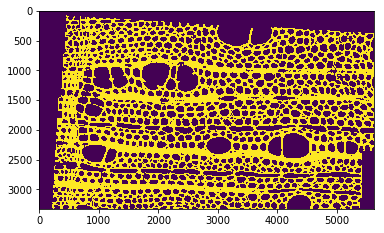

In [17]:
cwall_mat=np.where(MFA>0, 255, 0)

plt.imshow(cwall_mat)

In [32]:
#call class
length_list=np.repeat(int(6/resolution) , len(df)+1)
cellwall_auto_measure_mp=cellwall_measure_mp(core_num, np.uint(cwall_mat), nuclei, resolution, length_list, cwall_thres=90)

with Pool(core_num) as p:
    #calculation MFA using cores 
    callback_cw = p.map(cellwall_auto_measure_mp.cwall_measure_mp, range(core_num))

100%|██████████| 268/268 [02:35<00:00,  2.54it/s]


In [33]:
result_list=[]
for i in tqdm(range(len(callback_cw))):
    result_list.extend(callback_cw[i])
    
cw_list=[result_list[i][0] for i in range(len(result_list))]
label_list=[result_list[i][1] for i in range(len(result_list))]

100%|██████████| 8/8 [00:00<00:00, 16955.25it/s]


In [34]:
cwall_median=[np.median(cw_list[i]) for i in range(len(cw_list))]
cwall_mean=[np.mean(cw_list[i]) for i in range(len(cw_list))]
cwall_std=[np.std(cw_list[i]) for i in range(len(cw_list))]

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          9.,  12.,  20.,  18.,  21.,  37.,  46.,  73.,  84.,  96.,  95.,
        107.,  84.,  84.,  68.,  47.,  58.,  43.,  41.,  30.,  17.,  24.,
         11.,  10.,  15.,   5.,   6.,   6.,  11.,   8.,   4.,   3.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.]),
 array([1.00000e-03, 1.20980e-01, 2.40960e-01, 3.60940e-01, 4.80920e-01,
        6.00900e-01, 7.20880e-01, 8.40860e-01, 9.60840e-01, 1.08082e+00,
        1.20080e+00, 1.32078e+00, 1.44076e+00, 1.56074e+00, 1.68072e+00,
        1.80070e+00, 1.92068e+00, 2.04066e+00, 2.16064e+00, 2.28062e+00,
        2.40060e+00, 2.52058e+00, 2.64056e+00, 2.76054e+00, 2.88052e+00,
        3.00050e+00, 3.12048e+00, 3.24046e+00, 3.36044e+00, 3.48042e+00,
        3.60040e+00, 3.72038e+00, 3.84036e+00, 3.96034e+00, 4.08032e+00,
        4.20030e+00, 4.32028e+00, 4.44026e+00, 4.56024e+00, 4.68022e+00,
        4.80020e+00, 4.92018e+00, 5.04016e+00, 5.16014e+00, 5.28012e+00,
 

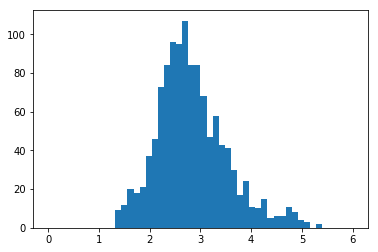

In [36]:
plt.hist(cwall_mean, bins=50, range=(0.001, 6))

In [42]:
df["cwall_mean"]=cwall_mean[1:]

In [44]:
cwall_mat=np.zeros((nuclei.shape[0], nuclei.shape[1]))
for index in tqdm(df.index):
    ind=np.where(nuclei==index)
    cwall_mat[ind]=df[df.index==index]["cwall_mean"].values[0]

100%|██████████| 2140/2140 [02:32<00:00, 14.09it/s]


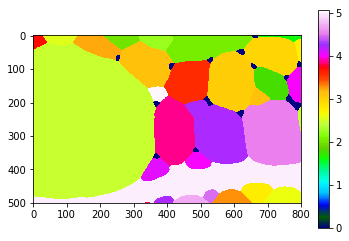

In [52]:
plt.imshow(cwall_mat[2000:2500, 4200:5000], cmap="gist_ncar")
plt.colorbar()
plt.show()

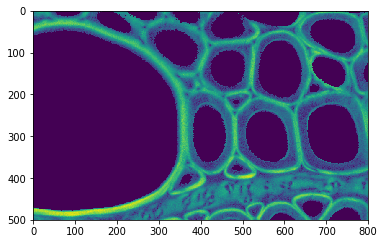

In [53]:
plt.imshow(MFA[2000:2500, 4200:5000])

データのロード

In [3]:
npz=np.load(target_npz_path[0])
nuclei=npz["nuclei"]
UV_im=npz["UV_im"]
lumen_im=npz["result_mat"]

df=pd.read_csv(prop_file_path[0])

細胞壁の2値化画像の作成

In [4]:
#create image for measuring lumen properties
#threshold = threshold_otsu(UV_im_gray)
#lumen_binary=(UV_im_gray<threshold)*255

#get lumen labeled image
#lumen_im=np.where(lumen_binary==0, 0, nuclei)
cwall_mat=np.zeros((lumen_im.shape[0], lumen_im.shape[1]))

#ノイズ除去, 時間がかかるのでregion propsで置き換えたほうがよい
for label in tqdm(np.unique(lumen_im.flatten())[1:]):
    lumen_im_binary=np.where(lumen_im==label, 255, 0)
    
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(lumen_im_binary))
    
    if len(stats[1:, 4])==0:
        pass
    else:
        target_label_ind=np.argmax(stats[1:, 4])
        label_list=np.arange(retval)[1:]
        target_ind=np.where(labels==label_list[target_label_ind])
        cwall_mat[target_ind]=255

100%|██████████| 2837/2837 [13:30<00:00,  3.49it/s]


In [12]:
#call class
core_num=8
length_list=np.repeat(int(6/resolution) , len(df)+1)
cellwall_auto_measure_mp=cellwall_measure_mp(core_num, np.uint(cwall_mat), nuclei, resolution, length_list, cwall_thres=90)

with Pool(core_num) as p:
    #calculation MFA using cores 
    callback_cw = p.map(cellwall_auto_measure_mp.cwall_measure_mp, range(core_num))

100%|██████████| 420/420 [05:40<00:00,  1.84it/s]


In [13]:
result_list=[]
for i in tqdm(range(len(callback_cw))):
    result_list.extend(callback_cw[i])
    
cw_list=[result_list[i][0] for i in range(len(result_list))]
label_list=[result_list[i][1] for i in range(len(result_list))]

100%|██████████| 8/8 [00:00<00:00, 19599.55it/s]


In [19]:
cwall_median=[np.median(cw_list[i]) for i in range(len(cw_list))]
cwall_mean=[np.mean(cw_list[i]) for i in range(len(cw_list))]
cwall_std=[np.std(cw_list[i]) for i in range(len(cw_list))]

dfに追加

In [20]:
df["cwall_mean"]=cwall_mean[1:]
df["cwall_std"]=cwall_std[1:]

In [21]:
df.to_csv(os.path.join(props_path, "cell_properties.csv"), index=False)